In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

# 16 Reproduce CIFAR10 

Reproducing CIFAR10 results from https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py 

I reproduced the results for resnet up to a validation accuracy of 91.66% with step learning rate
The Residual option B is better than A! -> use B always

## A. Experiment config

### Config file

In [74]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1,2]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [42]

# sweep:
#   type: grid
#   axes: 
#   - parameter: trainer.batch_size
#     vals: [256, 512, 1024]
    
start_num: 0

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '16.4'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-myresnet-A-defaulthyps
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-cifar10-A #lenet_300_100_relu_cifar10 #
    # name: resnetcifar10
    # model_kwargs: 
    #   resnet_type: resnet20

  trainer:
    training_setup: supervised
    n_steps: 64e3
    log_train_step_every: 1
    val_every: 500
    save_every: 64e3
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1 
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [32e3, 48e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    clip_grad_norm: 

  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(config_yaml)

In [75]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run.py --config-name cifar10-16.4.0-myresnet-A-defaulthyps.yaml


In [7]:
cfg_yaml = """
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      seed: 0
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(cfg_yaml)

In [9]:
from ml_utilities.data import get_dataset_class
from ml_utilities.data.data_utils import calculate_dataset_mean_std
cf10 = get_dataset_class('cifar10')('/system/user/beck/pwbeck/data')

Files already downloaded and verified


In [10]:
len(cf10), cf10.normalizer_values

(50000,
 {'mean': [0.4913995563983917, 0.48215848207473755, 0.44653093814849854],
  'std': [0.20230084657669067, 0.19941289722919464, 0.20096157491207123]})

### Check if normalizer values are wrong? No, they are the same as in pytorch lightning

In [12]:
from torchvision.datasets import CIFAR10
import torchvision

In [14]:
cf10 = CIFAR10(root='/system/user/beck/pwbeck/data/cifar', train=True, transform=torchvision.transforms.ToTensor())

In [17]:
calculate_dataset_mean_std(cf10, batch_size=1)

100%|██████████| 50000/50000 [00:10<00:00, 4740.42it/s]


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

### check dataset seed: are different splits of the dataset generated? YES

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


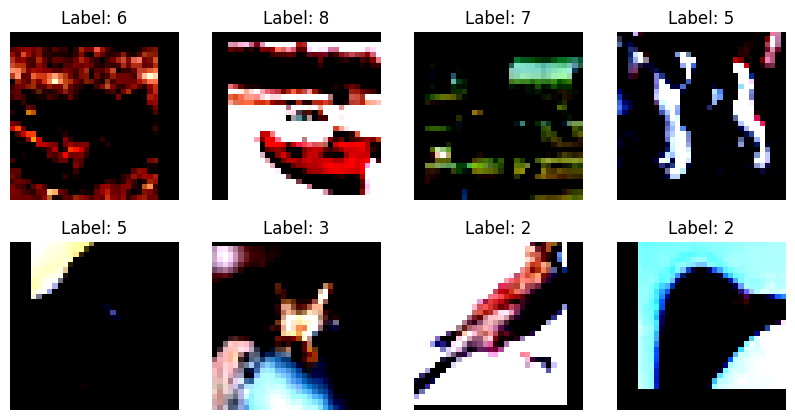

In [22]:
%autoreload 2
from ml_utilities.data.datasetgenerator import DatasetGenerator
from ml_utilities.data.data_utils import show_images

cfg_yaml = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    seed: 0
  train_split_transforms:
    image_transforms:
    - RandomHorizontalFlip
    - RandomCrop:
        size: 32
        padding: 4
    tensor_transforms: 
    joint_tensor_transforms: 
    enable_transforms: True
"""
cfg = OmegaConf.create(cfg_yaml)

ds_gen = DatasetGenerator(**cfg.data)
ds_gen.generate_dataset()
show_images(ds_gen.train_split, num_images=10, shuffle=False)


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


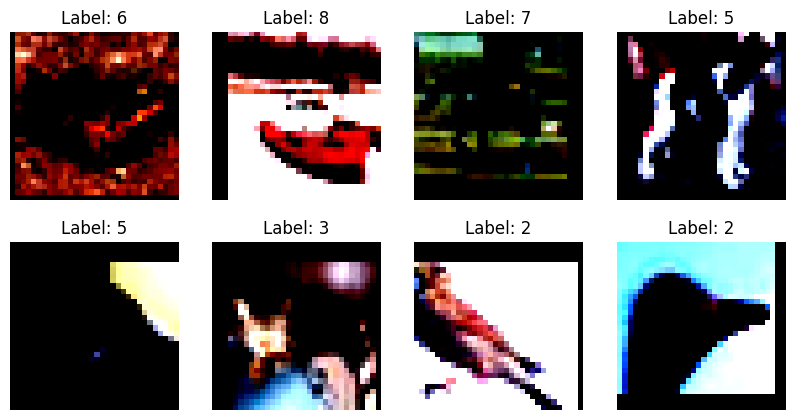

In [23]:
%autoreload 2
from ml_utilities.data.datasetgenerator import DatasetGenerator
from ml_utilities.data.data_utils import show_images

cfg_yaml = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    seed: 0
  train_split_transforms:
    image_transforms:
    - RandomHorizontalFlip
    - RandomCrop:
        size: 32
        padding: 4
    tensor_transforms: 
    joint_tensor_transforms: 
    enable_transforms: True
"""
cfg = OmegaConf.create(cfg_yaml)

ds_gen = DatasetGenerator(**cfg.data)
ds_gen.generate_dataset()
show_images(ds_gen.train_split, num_images=10, shuffle=False)

### load batches 500, 501, 502

In [40]:
import numpy as np

In [52]:
batch_dir = Path('/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/cifar10-16.1.3-resnet-repr-lr0.1--230120_100811')

In [53]:
batches = {idx: torch.load(batch_dir/f'batch{idx}.p') for idx in [499, 500, 501, 502]}

In [57]:
batches[501][0].shape

torch.Size([128, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

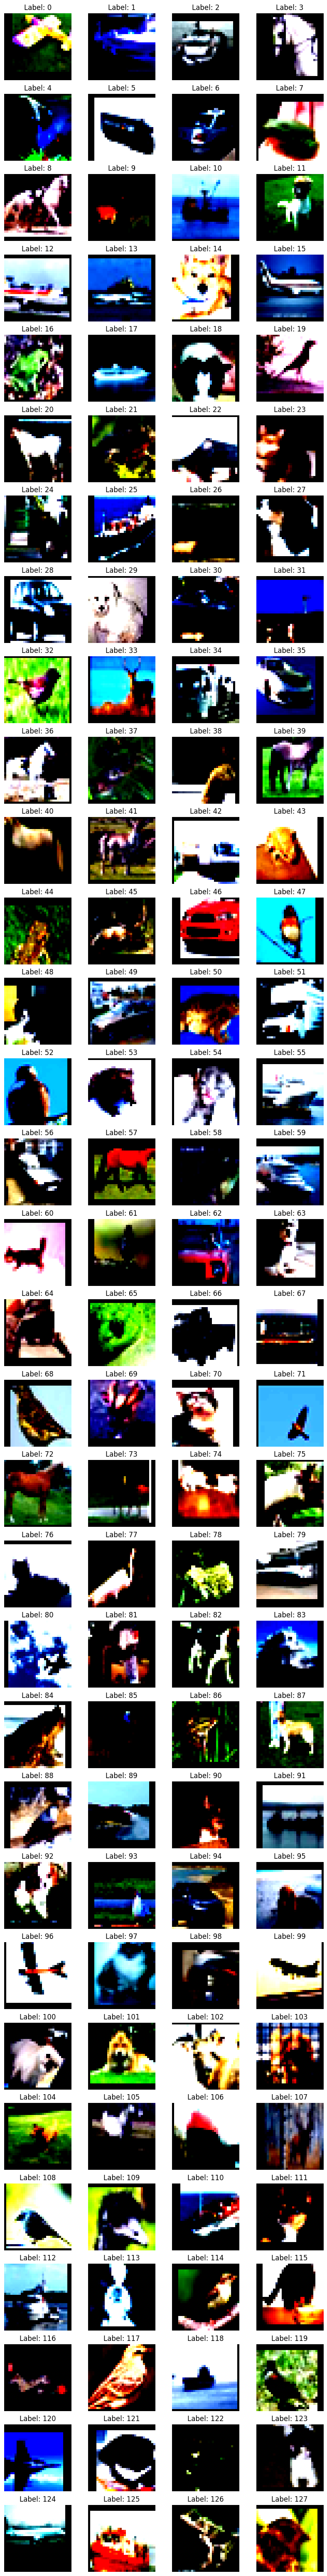

In [59]:
show_images(batches[501][0], num_images=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

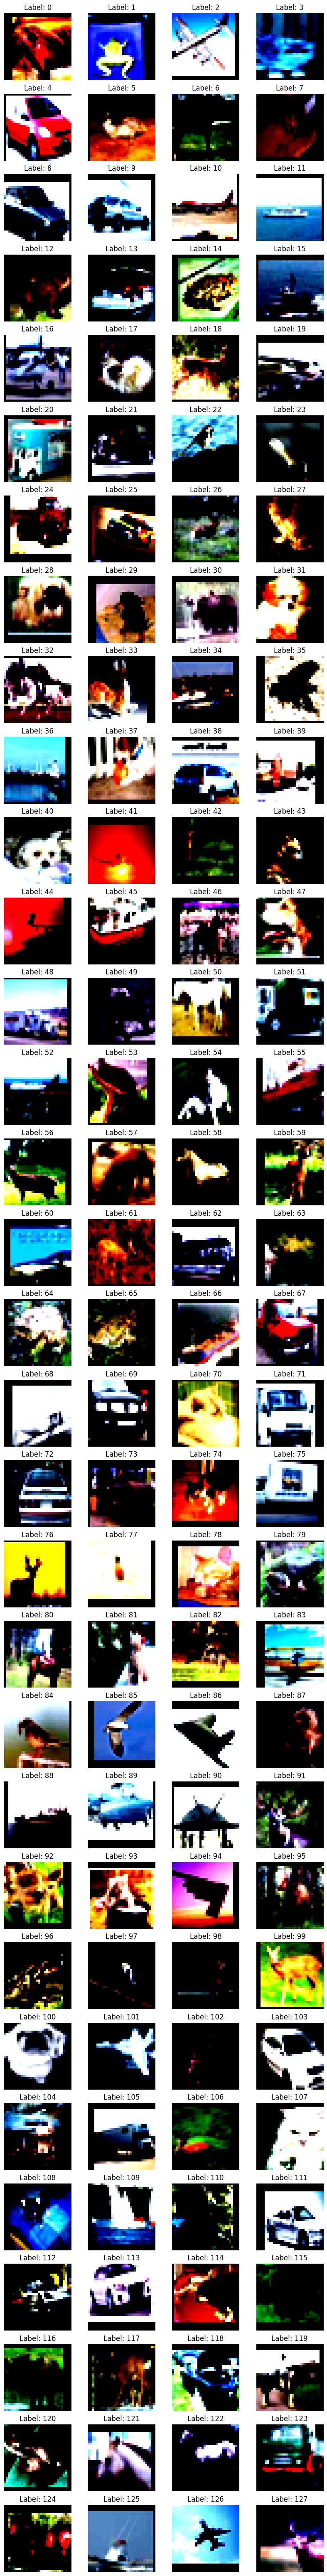

In [60]:
show_images(batches[500][0], num_images=128, shuffle=False)

### Sweep result

In [ ]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

In [ ]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

In [3]:
# copy config.yaml

sp = Path('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs')
list(sp.iterdir())

[PosixPath('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs/IA-B-cifar10-15.2.1-resnet-B--checkpoint_idx-1000-seed-1--230117_164122'),
 PosixPath('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs/IA-B-cifar10-15.2.1-resnet-B--checkpoint_idx-0-seed-1--230117_172312'),
 PosixPath('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs/IA-B-cifar10-15.2.1-resnet-B--checkpoint_idx-15000-seed-1--230117_175748'),
 PosixPath('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs/IA-B-cifar10-15.2.1-resnet-B--checkpoint_idx-10000-seed-1--230117_164120'),
 PosixPath('/system/user/beck/pwbeck/projects/regularization/erank/outputs/IA-B-cifar10-15.2.1-resnet-B--230117_164107/outputs/IA-B-cifar10-15.2.1-resnet-B--checkpoint_idx-50-seed-1--230117_164

In [4]:
for p in sp.iterdir():
    config = OmegaConf.load(p/'.hydra' / 'config.yaml')
    OmegaConf.save(config, p / 'config.yaml')

## B. Analysis 1

In [ ]:
pprint(sweepr.available_log_columns)

In [ ]:
sw_summary = sweepr.get_summary()

In [ ]:
sw_summary